In [1]:
#Cargando librerías 

from IPython.display import clear_output
import importlib

from PIL import Image
import matplotlib.pyplot as plt
import scipy as sp
#from scipy import ndimage as ndi
import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import src.positioning_sensors as ps
importlib.reload(ps)

import src.regionGrowing as rg
importlib.reload(rg)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)


from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

from skimage.draw import line

In [2]:
fn = "linz_with_init_net.txt"
me.createProject(fn)

Read File: ../experiments/linz_with_init_net.txt
Creating Directory in: ../experiments/linz_experiment_with_initial_positions/
Creating Directory ../experiments/linz_experiment_with_initial_positions/results/
Creating Directory: ../experiments/linz_experiment_with_initial_positions/semivariances/
Copy linz_with_init_net.txt -> ../experiments/linz_experiment_with_initial_positions/linz_with_init_net.txt


In [3]:
setup = me.readConfigFile(fn)

In [4]:
setup['init_fixed_net']

[[34, 34], [34, 31], [35, 29], [36, 39], [39, 22]]

In [5]:
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


In [6]:
#cargamos imagenes en luminance e importance

ilumina = cfg.data + setup["folder_input"] + setup["input_ntli"]
niveles = cfg.data + setup["folder_input"] + setup["input_evm"]

img = ilumina
im1 = np.array(Image.open(img))


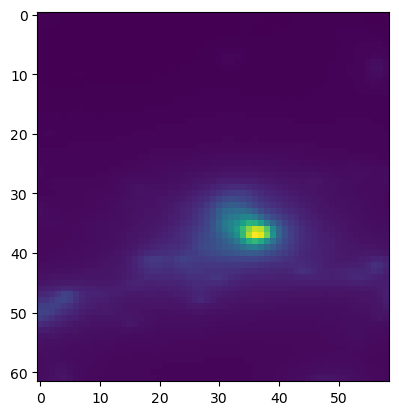

In [7]:
plt.imshow(im1)

In [8]:
net = setup["init_fixed_net"]

In [9]:
#NTLI: luminance
NTLI = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles, invert = True)

th = int(setup["desaturation_th"])

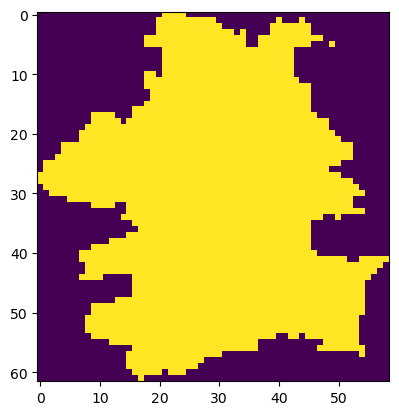

In [10]:
plt.imshow(EAM)

In [11]:
#smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y, sigma_x]

FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI, 
                                            sigma, 
                                            mode = setup['gaussian_mode'])


#we filter only the values greater than 22
th = setup['neglect_values']/8
FDNTLI = (FDNTLI>=th)*FDNTLI

nonsatc = np.copy(FDNTLI)

#
#nonsatc[si] = 0
#plt.imshow(nonsatc)
#plt.show()

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_57946/1932599856.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI,


In [12]:
fxn = setup["init_fixed_net"]

In [13]:
semivariograms = np.zeros((5, FDNTLI.shape[0], FDNTLI.shape[1]))
collection_masks = np.zeros((5, FDNTLI.shape[0], FDNTLI.shape[1]))

In [14]:
#semivariograms[0] = np.copy(sv)

In [15]:
#semivariograms[0]

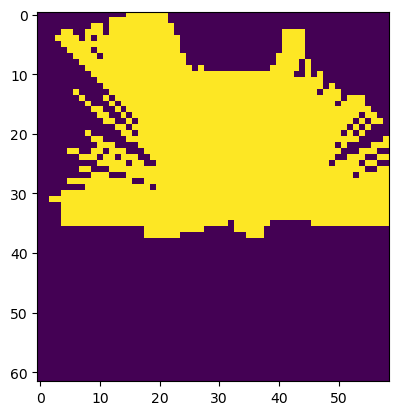

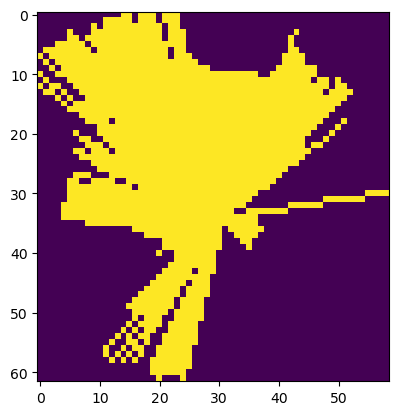

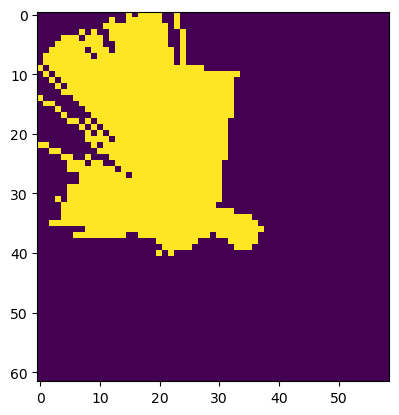

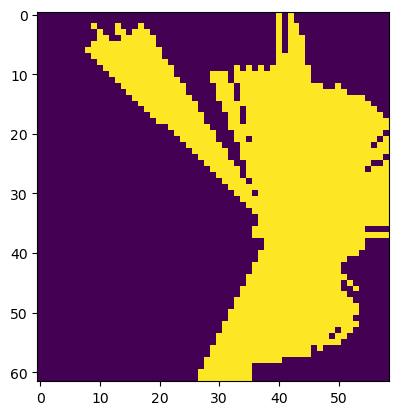

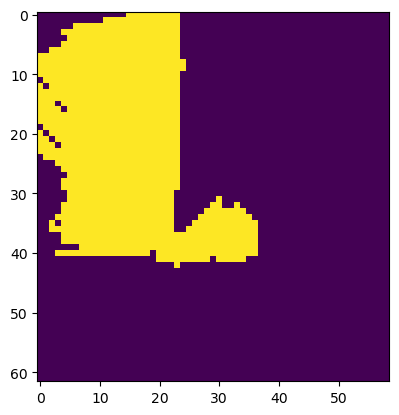

In [16]:
params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


for i, s in enumerate(fxn):

    si = tuple(s)

    FDNTLI_LINZ = np.copy(FDNTLI)
    FDNTLI_LINZ[si]=np.max(FDNTLI_LINZ)

  #  plt.imshow(FDNTLI_LINZ)
    
    rG = rg.rGrowing(FDNTLI)


    rG.setParams(params)
  
    sv = rG.makeSemivarianceMap(si)
    svc = np.copy(sv)
    
    
    #svc[si] = np.max(sv)

    
    masksv = ps.constructMask(si, sv, flat_means_decrease)
    #svc[si] = 0.00000000000000000001
    
    masksv[si] = 1
    
    plt.imshow(masksv)
    
    semivariograms[i] = np.copy(svc)
    collection_masks[i] = np.copy(masksv)
    
    plt.show()


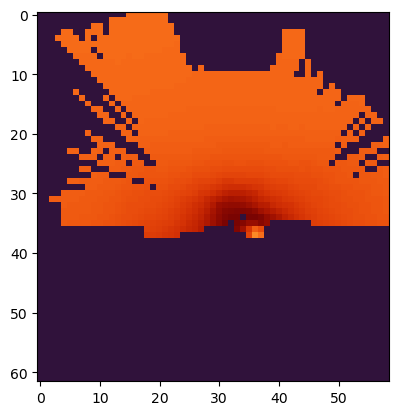

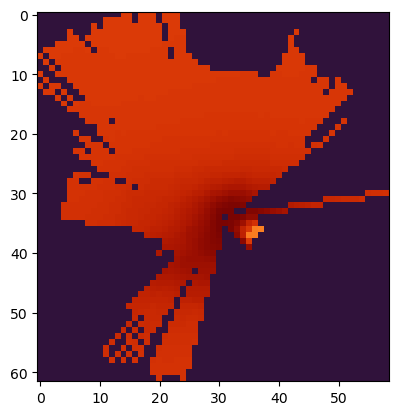

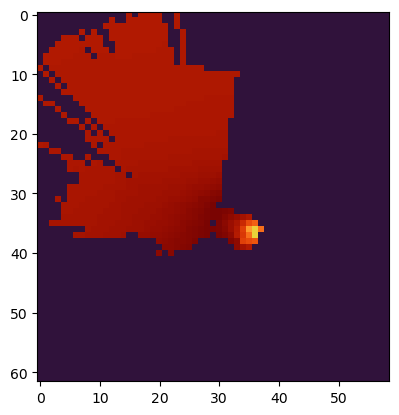

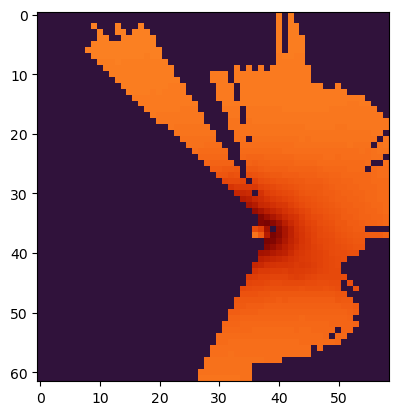

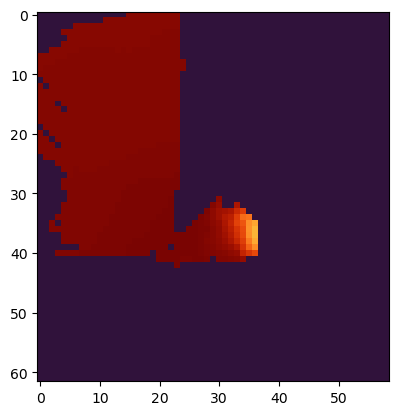

In [18]:
import matplotlib as mpl
covers = np.zeros((6, FDNTLI.shape[0], FDNTLI.shape[1]))
i = 0 
for i in range(1, 6):
    ntli_max = FDNTLI.max()
    Rp = (0.5*ntli_max**2 -semivariograms[i-1])/(0.5*ntli_max**2) 
    M = np.copy(Rp*collection_masks[i-1])

    M[tuple(fxn[i-1])]=0
    #M[tuple((fxn[i][0]+1, fxn[i][1]))]= 0
    #M[tuple((fxn[i][0]-1, fxn[i][1]))]= 0
    #M[tuple((fxn[i][0], fxn[i][1]+1))]= 0
    #M[tuple((fxn[i][0], fxn[i][1]-1))]= 0

    plt.imshow(M, cmap=mpl.colormaps["turbo"])
    covers[i] = M
    plt.show()


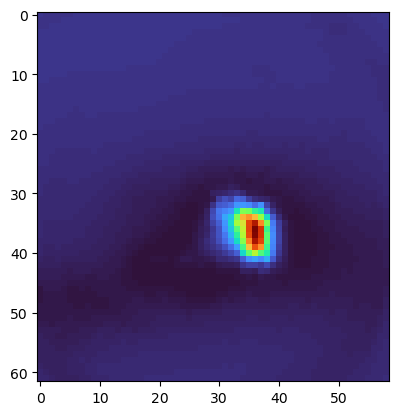

In [19]:

plt.imshow(semivariograms[i-1], cmap=mpl.colormaps["turbo"])


In [20]:
def plot_Locations(M, L, mn = 1, mx = 2):
    
    import itertools as it
    
    for loc in L:
        for i in it.product([0,1,2], [0,1,2]): 
            if loc[0]+i[0]-1 >= 0 and loc[0]+i[0]-1 < M.shape[0] and (loc[1] + i[1]-1)>=0 and (loc[1] + i[1]-1)<M.shape[1]:
                tup = (loc[0]+i[0]-1, loc[1] + i[1]-1)
                M[tup] = mx
        M[tuple(loc)] = mn
    return M

In [21]:
Rpp = plot_Locations(M*Rp, [s], mn = 0.1, mx = 1.4)

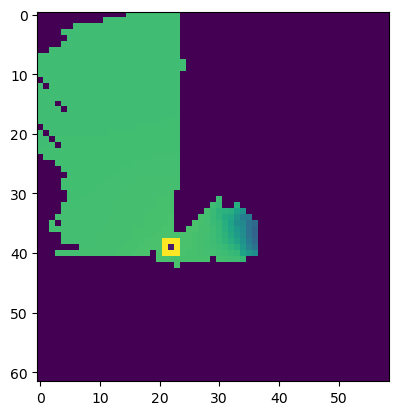

In [22]:
plt.imshow(Rpp)

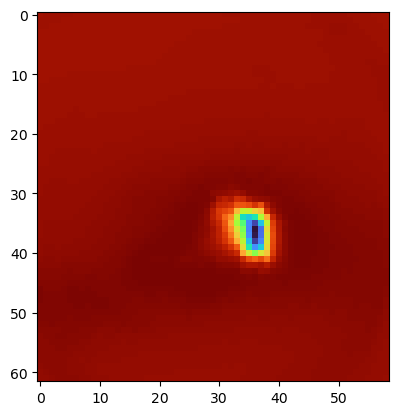

In [23]:
#poner en color gris los valores = 0
plt.imshow(Rp,cmap=mpl.colormaps["turbo"])

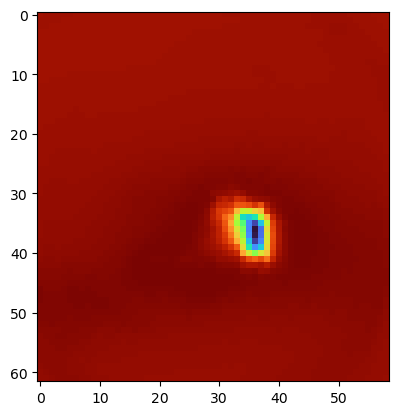

In [24]:
#poner en color gris los valores = 0
plt.imshow(Rp,cmap=mpl.colormaps["turbo"])

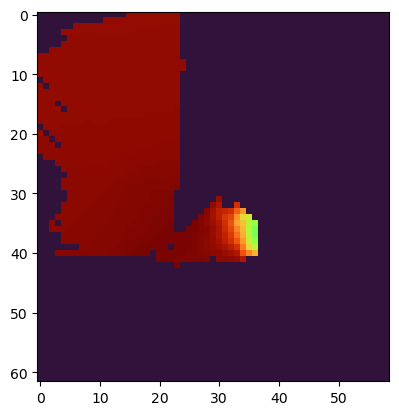

In [25]:
#poner en color gris los valores = 0
plt.imshow(M*Rp,cmap=mpl.colormaps["turbo"])

In [26]:
#mpl.colormaps["turbo"]

In [27]:
[i for i in mpl.colormaps]

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

In [28]:
import matplotlib
from matplotlib import cm
turbo = mpl.colormaps["cividis"]
newcolors = np.copy(turbo.colors)



In [29]:
gray = np.array([0.5, 0.5, 0.5])
#newcolors[0,:] = gray


In [30]:
tuple(s)

(39, 22)

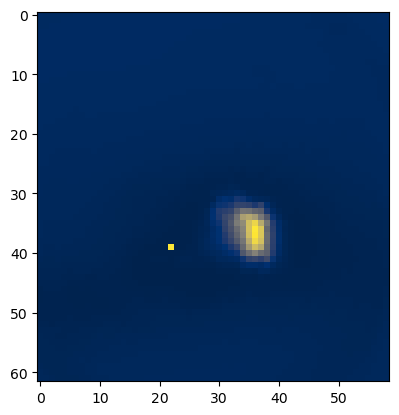

In [31]:
newcmp = matplotlib.colors.ListedColormap(newcolors)
i = 5
SV = (semivariograms[i-1]+0.1)
SV[tuple(s)] = np.max(SV)
plt.imshow(SV, cmap = newcmp)

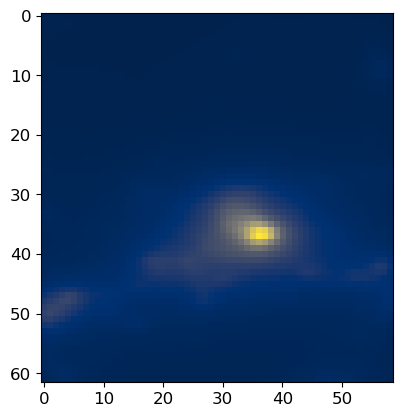

In [307]:
plt.imshow(FDNTLI, cmap = newcmp)

In [186]:

collection_masks[i-1][np.argwhere(collection_masks[i-1]==0)]



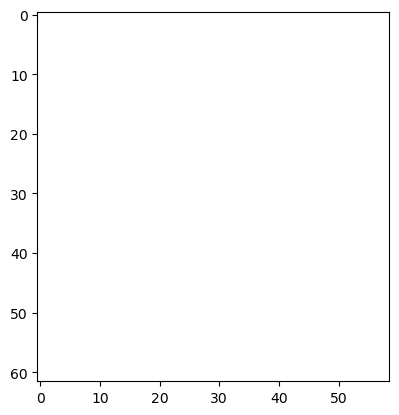

In [190]:
plt.imshow(collection_masks[i-1])

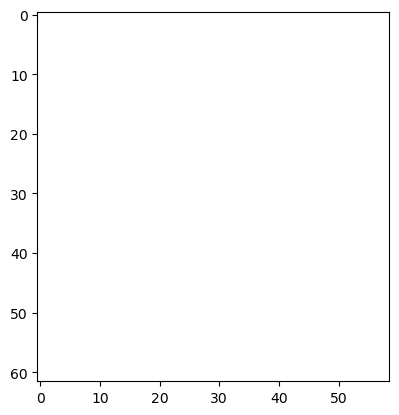

In [188]:
plt.imshow(collection_masks[i-1], cmap = newcmp)

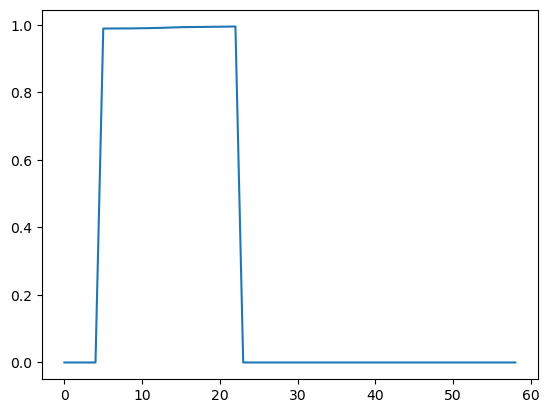

In [172]:
plt.plot(M[30,:])

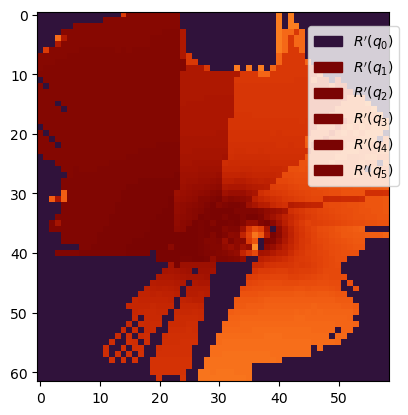

In [32]:
import matplotlib.patches as mpatches

im = plt.imshow(np.max(covers, axis=0),cmap=mpl.colormaps["turbo"])

values = np.unique(np.argmax(covers, axis=0).ravel())

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="$R'(q_{l})$".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.77, 0.96), loc=2, borderaxespad=0. )

plt.grid(False)
plt.show()




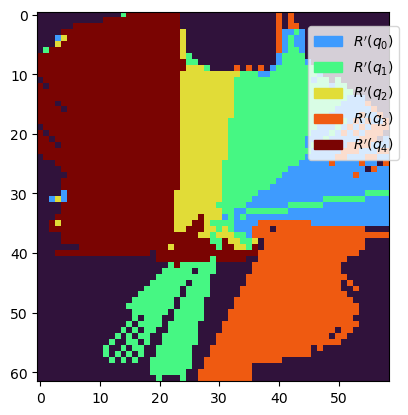

In [33]:
im = plt.imshow(np.argmax(covers, axis=0),cmap=mpl.colormaps["turbo"])

values = np.unique(np.argmax(covers, axis=0).ravel())

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="$R'(q_{l})$".format(l=values[i-1]) ) for i in range(1,len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.77, 0.96), loc=2, borderaxespad=0. )

plt.grid(False)
plt.show()




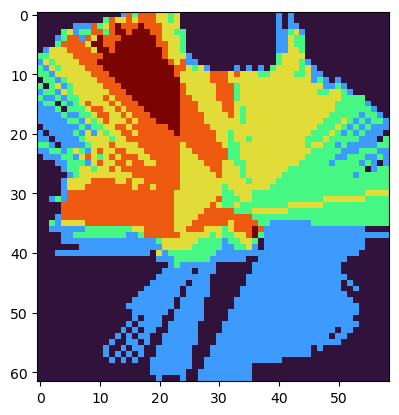

In [34]:
plt.imshow(np.sum(collection_masks, axis=0),cmap=mpl.colormaps["turbo"])

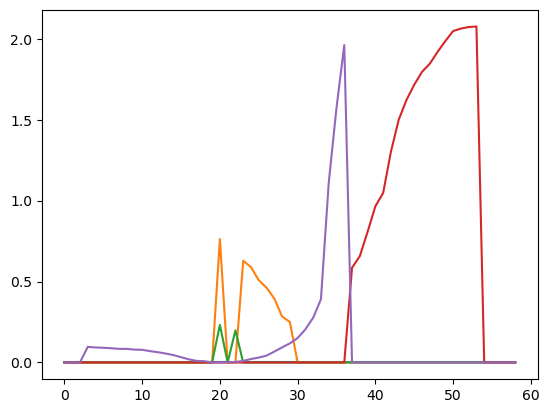

In [19]:
plt.plot(semivariograms[:,40,:].T)

In [118]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


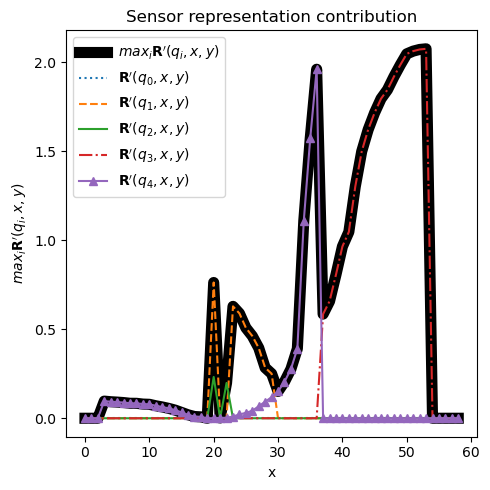

In [139]:

y = 40
maxy = semivariograms[:, y, :].T.max(axis = 1)
plt.title("Sensor representation contribution")
plt.plot(maxy, "k", linewidth = 8, label = "$max_i \mathbf{R}' (q_i, x, y)$" )
plt.fill_between(0, maxy, step="pre", alpha=0.4)
styles = [":", "--", "", "-.", "-^"]
for i in range(5):
    plt.plot(semivariograms[i, y, :].T, styles[i] ,linewidth = 1.5, label = "$\mathbf{R}'"+"(q_{x}, x, y)$".format(x=i))

plt.ylabel("$max_i \mathbf{R}' (q_i,x,y)$")
plt.xlabel("x")

plt.legend()
plt.savefig("maxi.eps", dpi = 300)




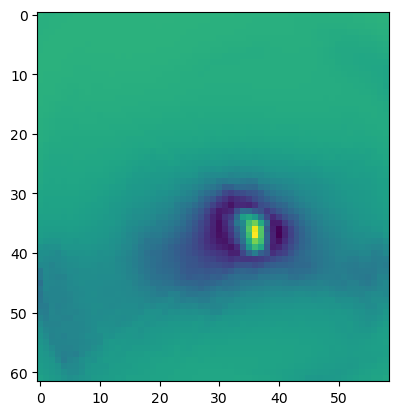

In [48]:
plt.imshow(semivariograms.max(axis=0))

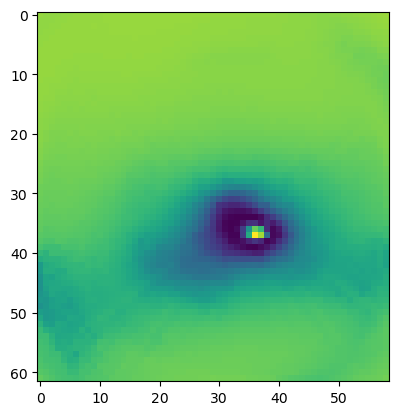

In [75]:
plt.imshow(semivariograms[0])

In [51]:
semivariograms[1]

array([[1.62664679, 1.60977257, 1.60588058, ..., 1.62704773, 1.63501372,
        1.64920184],
       [1.60977257, 1.60588058, 1.6087499 , ..., 1.6172015 , 1.62560146,
        1.63418187],
       [1.60588058, 1.6131565 , 1.61831664, ..., 1.60449517, 1.61445978,
        1.62308941],
       ...,
       [1.34660704, 1.32403791, 1.3019713 , ..., 1.43446834, 1.44596514,
        1.45553454],
       [1.37963768, 1.35520356, 1.32403791, ..., 1.44596514, 1.45553454,
        1.46685442],
       [1.42748545, 1.37963768, 1.35520356, ..., 1.45553454, 1.46685442,
        1.49678332]])

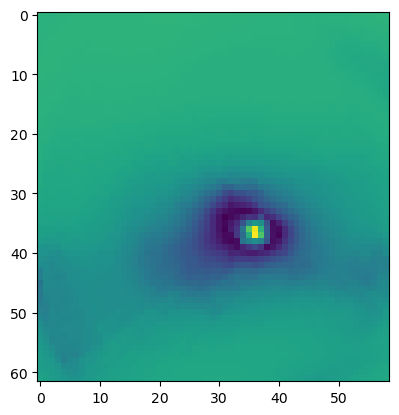

In [53]:
plt.imshow(semivariograms[:4].max(axis=0))

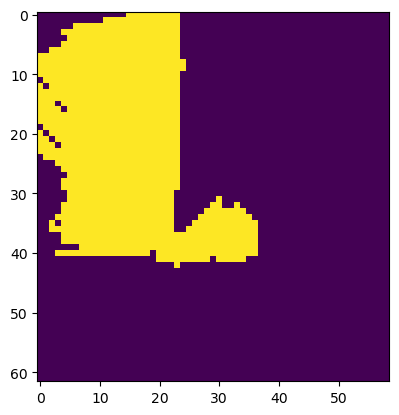

In [54]:
#np.unique(masksv)

plt.imshow(masksv)

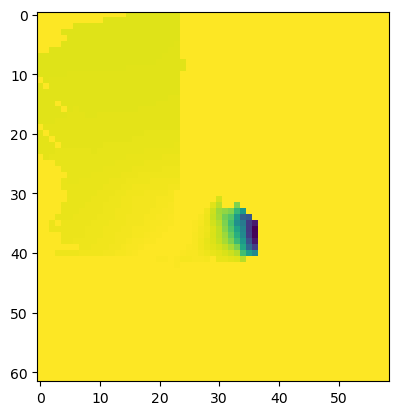

In [55]:

ss = np.copy(-svc)
plt.imshow(ss*masksv)


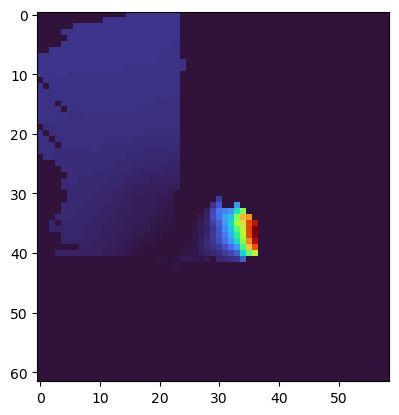

In [56]:

plt.imshow(masksv*svc, cmap="turbo")

In [19]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

matplotlib.colormaps['viridis']

print('viridis.colors', viridis.colors)

print('viridis(range(12))', viridis(range(40)))

print('viridis(np.linspace(0, 1, 12))', viridis(np.linspace(0, 1, 12)))




NameError: name 'viridis' is not defined

In [ ]:
coords = ps.get_coords(FDNTLI>setup["neglect_values"])

#fill the required params
si = (28,19)

params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram

rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n, FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()
sv = rG.makeSemivarianceMap(si)
svc = np.copy(sv)
svc[si] = np.max(sv)
plt.imshow(svc)
masksv = ps.constructMask(si, sv, flat_means_decrease)
masksv[si] = 0
plt.imshow(masksv*svc)

In [ ]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
gray = np.array([128/256, 128/256, 128/256, 1])
newcolors[:1, :] = gray
newcmp = ListedColormap(newcolors)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)41029


In [ ]:
plt.imshow(semivariograms[0])

In [ ]:
semivariograms[0]

In [ ]:
semivariograms[0].shape[0]

In [ ]:
SS = semivariograms[0]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.arange(semivariograms[0].shape[0]), np.arange(semivariograms[0].shape[1]))

#xx, yy = np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,30))

# create some dummy data (20 x 20) for the image
data = semivariograms[0]

# create vertices for a rotated mesh (3D rotation matrix)
X = np.sqrt(1./3) * xx + np.sqrt(1./3) * yy
X = xx
Y = -np.sqrt(1./3) * xx + np.sqrt(1./3) * yy
Y = yy
Z = np.ones(semivariograms[0].shape)
Z1 = np.ones(semivariograms[1].shape)*10

# create the figure
fig = plt.figure()

# show the reference image
ax1 = fig.add_subplot(121)
ax1.imshow(data, cmap=plt.cm.BrBG, interpolation='nearest', origin='lower', extent=[0,1,0,1])


# show the 3D rotated projection
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z.T, rstride=1, cstride=1, facecolors=plt.cm.BrBG(semivariograms[0].T), shade=False)
ax2.plot_surface(X, Y, Z1.T, rstride=1, cstride=1, facecolors=plt.cm.BrBG(semivariograms[1].T), shade=False)
ax2.plot_surface(X, Y, Z1.T*2, rstride=1, cstride=1, facecolors=plt.cm.BrBG(semivariograms[2].T), shade=False)
ax2.plot_surface(X, Y, Z1.T*3, rstride=1, cstride=1, facecolors=plt.cm.BrBG(semivariograms[3].T), shade=False)

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection = '3d')

xx, yy = np.meshgrid(np.arange(semivariograms[0].shape[0]), np.arange(semivariograms[0].shape[1]))

  

x = np.copy(xx)
y = np.copy(yy)
z = np.ones(semivariograms[0].shape)


ax.plot3D(x, y, z.T)
  
ax.view_init(-160, 60)
plt.show()

In [ ]:
plt.imshow(data)

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()


z1 = [
    [8.83,8.89,8.81,8.87,8.9,8.87],
    [8.89,8.94,8.85,8.94,8.96,8.92],
    [8.84,8.9,8.82,8.92,8.93,8.91],
    [8.79,8.85,8.79,8.9,8.94,8.92],
    [8.79,8.88,8.81,8.9,8.95,8.92],
    [8.8,8.82,8.78,8.91,8.94,8.92],
    [8.75,8.78,8.77,8.91,8.95,8.92],
    [8.8,8.8,8.77,8.91,8.95,8.94],
    [8.74,8.81,8.76,8.93,8.98,8.99],
    [8.89,8.99,8.92,9.1,9.13,9.11],
    [8.97,8.97,8.91,9.09,9.11,9.11],
    [9.04,9.08,9.05,9.25,9.28,9.27],
    [9,9.01,9,9.2,9.23,9.2],
    [8.99,8.99,8.98,9.18,9.2,9.19],
    [8.93,8.97,8.97,9.18,9.2,9.18]
]

z2 = [[zij+1 for zij in zi] for zi in z1]
z3 = [[zij-1 for zij in zi] for zi in z1]

data = [
    go.Surface(z=z1, colorscale='Electric', showscale=False),
    go.Surface(z=z2, opacity=0.9, colorscale='Viridis', showscale=True),
    go.Surface(z=z3, opacity=0.9, colorscale='Blues', showscale=False)

]

iplot(data)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.arange(sv.shape[0]), np.arange(sv.shape[1]))


X =  xx 
Y =  yy
Z =  10*np.ones(X.shape)
Z2 = 20*np.ones(X.shape)
Z3 = 30*np.ones(X.shape)

# create the figure
fig = plt.figure()

# show the reference image
ax1 = fig.add_subplot(121)
ax1.imshow(semivariograms[0], cmap=plt.cm.gnuplot, interpolation='none', origin='upper', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=2, cstride=1, facecolors=plt.cm.gnuplot(semivariograms[0].T), shade=False)
ax2.plot_surface(X, Y, Z2, rstride=2, cstride=1, facecolors=plt.cm.gnuplot(semivariograms[1].T), shade=False)
ax2.plot_surface(X, Y, Z3, rstride=2, cstride=1, facecolors=plt.cm.gnuplot(semivariograms[2].T), shade=False)

**Bibliografía**

Construir paleta de colores

https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html